# Week 3 Water Segmentation

In [2]:
!pip install -q rasterio albumentations==1.3.1 tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 111.2 MB/s eta 0:00:00


In [3]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import cv2, rasterio, albumentations as A

In [4]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [5]:
# Upload data.zip from your local machine
from google.colab import files

uploaded = files.upload()


Saving data.zip to data.zip


In [6]:
# Unzip into /content/data
!unzip -q /content/data.zip -d /content/

# Check folder structure
!ls /content/data


images	labels


In [7]:
DATA_DIR = '/content/data'
IM_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'labels')

assert os.path.exists(IM_DIR), f"Images directory not found: {IM_DIR}"
assert os.path.exists(MASK_DIR), f"Labels directory not found: {MASK_DIR}"


Utility loaders

In [8]:
def load_image_any(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == '.npy': return np.load(path)
    if ext in ('.tif','.tiff'):
        with rasterio.open(path) as src:
            arr = src.read()
            return np.transpose(arr,(1,2,0))
    arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if arr is None: raise RuntimeError(f"Unable to load image: {path}")
    return arr

def load_mask_any(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == '.npy': return (np.load(path).squeeze()>0).astype(np.uint8)
    try:
        with rasterio.open(path) as src:
            arr = src.read(1)
            return (arr>0).astype(np.uint8)
    except:
        m = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if m is None: raise RuntimeError(f"Unable to load mask: {path}")
        if m.ndim==3: m = m[:,:,0]
        return (m>0).astype(np.uint8)

Match images/masks

In [9]:
def idx_from_basename(p): return os.path.splitext(os.path.basename(p))[0]
image_files = sorted(glob.glob(os.path.join(IM_DIR,'*')))
mask_files = sorted(glob.glob(os.path.join(MASK_DIR,'*')))
image_map = {idx_from_basename(p):p for p in image_files}
mask_map = {idx_from_basename(p):p for p in mask_files}
common_keys = sorted(list(set(image_map)&set(mask_map)))
print(f'Found {len(common_keys)} matched pairs.')

Found 306 matched pairs.


 Load a sample

In [10]:
sample_key = common_keys[0]
img_sample = load_image_any(image_map[sample_key])
mask_sample = load_mask_any(mask_map[sample_key])
H,W = img_sample.shape[:2]
B = img_sample.shape[2] if img_sample.ndim==3 else 1
print("Sample HxW:",H,"x",W,"bands:",B)

Sample HxW: 128 x 128 bands: 12


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


 Load all data

In [11]:
N = len(common_keys)
X = np.zeros((N,H,W,12),dtype=np.float32)
Y = np.zeros((N,H,W),dtype=np.uint8)

for i,k in enumerate(tqdm(common_keys,desc='Loading')):
    im = load_image_any(image_map[k])
    m = load_mask_any(mask_map[k])
    if im.ndim==2: im = im[:,:,np.newaxis]
    if im.shape[2]>=12: im = im[:,:,:12]
    else:
        pad = np.zeros((H,W,12-im.shape[2]),dtype=im.dtype)
        im = np.concatenate([im,pad],axis=2)
    X[i]=im.astype(np.float32)
    if m.shape!=(H,W): m=cv2.resize(m,(W,H),interpolation=cv2.INTER_NEAREST)
    Y[i]=m.astype(np.uint8)

print("Loaded X:",X.shape,"Y:",Y.shape)


Loading: 100%|██████████| 306/306 [00:00<00:00, 313.00it/s]

Loaded X: (306, 128, 128, 12) Y: (306, 128, 128)


Train/val split + normalization

In [12]:
train_idx,val_idx=train_test_split(np.arange(N),test_size=0.2,random_state=42)
X_train,X_val,Y_train,Y_val=X[train_idx],X[val_idx],Y[train_idx],Y[val_idx]
band_means=X_train.reshape(-1,12).mean(0)
band_stds=X_train.reshape(-1,12).std(0)+1e-8
X=(X-band_means.reshape(1,1,1,12))/band_stds.reshape(1,1,1,12)

Augmentations

In [13]:
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

# Albumentations augmentations
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])


def augment_fn(image, mask):
    # image: H,W,12 float32
    # mask: H,W uint8
    aug = train_aug(image=image, mask=mask)
    return aug['image'], aug['mask']

def tf_preprocess(image, mask):
    image = tf.cast(image, tf.float32)
    mask = tf.expand_dims(tf.cast(mask, tf.float32), -1)
    return image, mask

def tf_augment(x, y):
    def aug_np(x_np, y_np):
        # Convert tensors to numpy arrays
        x_np = x_np.numpy() if isinstance(x_np, tf.Tensor) else x_np
        y_np = y_np.numpy() if isinstance(y_np, tf.Tensor) else y_np
        xi, yi = augment_fn(x_np.astype(np.float32), y_np.astype(np.uint8))
        return xi.astype(np.float32), yi.astype(np.uint8)

    x_aug, y_aug = tf.py_function(func=aug_np, inp=[x, y], Tout=[tf.float32, tf.uint8])
    x_aug.set_shape([H, W, 12])
    y_aug.set_shape([H, W])
    return x_aug, y_aug

# Create tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.map(tf_augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(tf_preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(200).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds = val_ds.map(tf_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


 U-Net

In [14]:
def conv_block(x,f):
    x=layers.Conv2D(f,3,padding='same',activation='relu')(x)
    x=layers.BatchNormalization()(x)
    x=layers.Conv2D(f,3,padding='same',activation='relu')(x)
    x=layers.BatchNormalization()(x)
    return x
def encoder_block(x,f):
    c=conv_block(x,f); p=layers.MaxPooling2D((2,2))(c); return c,p
def decoder_block(x,skip,f):
    x=layers.Conv2DTranspose(f,(2,2),strides=2,padding='same')(x)
    x=layers.concatenate([x,skip]); x=conv_block(x,f); return x
def build_unet(input_shape=(128,128,12)):
    inputs=layers.Input(shape=input_shape)
    c1,p1=encoder_block(inputs,16)
    c2,p2=encoder_block(p1,32)
    c3,p3=encoder_block(p2,64)
    c4,p4=encoder_block(p3,128)
    b=conv_block(p4,256)
    d1=decoder_block(b,c4,128)
    d2=decoder_block(d1,c3,64)
    d3=decoder_block(d2,c2,32)
    d4=decoder_block(d3,c1,16)
    outputs=layers.Conv2D(1,(1,1),activation='sigmoid',dtype='float32')(d4)
    return models.Model(inputs,outputs)

model=build_unet((H,W,12))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,744 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[

 Total params: 1,948,289 (7.43 MB)

 Trainable params: 1,945,345 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

Metrics

In [15]:
def iou_metric(y_true,y_pred,smooth=1e-6):
    y_true_f=K.flatten(y_true); y_pred_f=K.flatten(y_pred)
    inter=K.sum(y_true_f*y_pred_f)
    union=K.sum(y_true_f)+K.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)
def dice_coef(y_true,y_pred,smooth=1e-6):
    y_true_f=K.flatten(y_true); y_pred_f=K.flatten(y_pred)
    inter=K.sum(y_true_f*y_pred_f)
    return (2.*inter+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

opt=tf.keras.optimizers.Adam(1e-4)
opt=mixed_precision.LossScaleOptimizer(opt)
model.compile(optimizer=opt,loss='binary_crossentropy',
              metrics=[iou_metric,dice_coef])

 Callbacks

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(
    "/content/unet_best.h5",
    monitor="val_iou_metric",
    mode="max",
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor="val_iou_metric",
    patience=7,      # stop if no improvement for 7 epochs
    mode="max",
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, early_stop]


Loop training

In [18]:
TOTAL_EPOCHS = 30
STEP = 5
start_epoch = 0

# Initialize dictionary to accumulate history
all_history = {
    'loss': [],
    'val_loss': [],
    'dice_coef': [],
    'val_dice_coef': [],
    'iou_metric': [],
    'val_iou_metric': []
}

for e in range(start_epoch, TOTAL_EPOCHS, STEP):
    print(f"=== Training from epoch {e} to {min(e+STEP, TOTAL_EPOCHS)} ===")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch=e,
        epochs=min(e + STEP, TOTAL_EPOCHS),
        callbacks=callbacks
    )
    # Accumulate the history
    for key in all_history:
        all_history[key] += history.history[key]

=== Training from epoch 0 to 5 ===
Epoch 1/5
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - dice_coef: 0.6349 - iou_metric: 0.4781 - loss: 0.3462
Epoch 1: val_iou_metric did not improve from 0.48444
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - dice_coef: 0.6352 - iou_metric: 0.4783 - loss: 0.3440 - val_dice_coef: 0.6293 - val_iou_metric: 0.4666 - val_loss: 0.2450 - learning_rate: 5.0000e-05
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.6363 - iou_metric: 0.4750 - loss: 0.3144
Epoch 2: val_iou_metric did not improve from 0.48444
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - dice_coef: 0.6371 - iou_metric: 0.4760 - loss: 0.3140 - val_dice_coef: 0.6317 - val_iou_metric: 0.4680 - val_loss: 0.2446 - learning_rate: 5.0000e-05
Epoch 3/5
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.6398 - iou_metric: 0.4831 - loss: 0.3140
Epoch 3: val_iou_metric did not improve from 0.48444
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - dice_coef: 0.6411 - iou_metric: 0.4850 - loss: 0.3128 - val_di

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - dice_coef: 0.6206 - iou_metric: 0.4620 - loss: 0.3117 - val_dice_coef: 0.6495 - val_iou_metric: 0.4873 - val_loss: 0.2419 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 10.
=== Training from epoch 10 to 15 ===
Epoch 11/15
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.7155 - iou_metric: 0.5684 - loss: 0.2592
Epoch 11: val_iou_metric did not improve from 0.48727
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - dice_coef: 0.7124 - iou_metric: 0.5648 - loss: 0.2614 - val_dice_coef: 0.6382 - val_iou_metric: 0.4740 - val_loss: 0.2448 - learning_rate: 2.5000e-05
Epoch 12/15
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.6062 - iou_metric: 0.4531 - loss: 0.3420
Epoch 12: val_iou_metric did not improve from 0.48727
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - dice_coef: 0.6096 - iou_metric: 0.4568 - loss: 0.3393 - val_dice_coef: 0.6433 - val_iou_metric: 0.4794 - val_loss: 0.2508 - learning_rate: 2.5000e-05
Epo

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - dice_coef: 0.6698 - iou_metric: 0.5154 - loss: 0.2957 - val_dice_coef: 0.6533 - val_iou_metric: 0.4909 - val_loss: 0.2323 - learning_rate: 2.5000e-05
Epoch 14/15
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.6090 - iou_metric: 0.4509 - loss: 0.3257
Epoch 14: val_iou_metric did not improve from 0.49087
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - dice_coef: 0.6108 - iou_metric: 0.4536 - loss: 0.3257 - val_dice_coef: 0.6437 - val_iou_metric: 0.4799 - val_loss: 0.2430 - learning_rate: 2.5000e-05
Epoch 15/15
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - dice_coef: 0.6458 - iou_metric: 0.5028 - loss: 0.3008
Epoch 15: val_iou_metric did not improve from 0.49087
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - dice_coef: 0.6464 - iou_metric: 0.5028 - loss: 0.3002 - val_dice_coef: 0.6530 - val_iou_metric: 0.4902 - val_loss: 0.2382 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 13.
=== Training from epoch 15 to 20 ===
Epo

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - dice_coef: 0.6676 - iou_metric: 0.5143 - loss: 0.2958 - val_dice_coef: 0.6547 - val_iou_metric: 0.4921 - val_loss: 0.2375 - learning_rate: 2.5000e-05
Epoch 17/20
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - dice_coef: 0.6868 - iou_metric: 0.5402 - loss: 0.3089
Epoch 17: val_iou_metric improved from 0.49210 to 0.49775, saving model to /content/unet_best.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - dice_coef: 0.6834 - iou_metric: 0.5365 - loss: 0.3087 - val_dice_coef: 0.6596 - val_iou_metric: 0.4978 - val_loss: 0.2308 - learning_rate: 2.5000e-05
Epoch 18/20
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.6445 - iou_metric: 0.4991 - loss: 0.3090
Epoch 18: val_iou_metric did not improve from 0.49775
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - dice_coef: 0.6451 - iou_metric: 0.4992 - loss: 0.3086 - val_dice_coef: 0.6556 - val_iou_metric: 0.4939 - val_loss: 0.2350 - learning_rate: 2.5000e-05
Epoch 19/20
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.6952 - iou_metric: 0.5477 - loss: 0.2740
Epoch 19: val_iou_metric did not improve from 0.49775
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - dice_coef: 0.6922 - iou_metric: 0.5444 - loss: 0.2754 - val_dice_coef: 0.6571 - val_iou_metric: 0.4952 - val_loss: 0.2308 - learning_rate: 2.5000e-05
Epoch 20/20
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dice_coef: 0.6810 - iou_metric: 0.5282 - loss:

Evaluate and save metrics + predictions

In [19]:
os.makedirs('/content/report', exist_ok=True)

val_preds = model.predict(X_val, batch_size=BATCH_SIZE)
val_preds_bin = (val_preds.squeeze() >= 0.5).astype(np.uint8)

ious, precisions, recalls, f1s = [], [], [], []

for i in range(len(Y_val)):
    y_true = Y_val[i].ravel()
    y_pred = val_preds_bin[i].ravel()

    inter = np.logical_and(y_true==1, y_pred==1).sum()
    union = np.logical_or(y_true==1, y_pred==1).sum()
    iou = inter/union if union>0 else (1.0 if y_true.sum()==0 and y_pred.sum()==0 else 0.0)
    ious.append(iou)

    precisions.append(precision_score(y_true, y_pred, zero_division=1))
    recalls.append(recall_score(y_true, y_pred, zero_division=1))
    f1s.append(f1_score(y_true, y_pred, zero_division=1))

with open('/content/report/metrics.txt','w') as f:
    f.write(f"mean_iou: {np.mean(ious):.4f}\n")
    f.write(f"mean_precision: {np.mean(precisions):.4f}\n")
    f.write(f"mean_recall: {np.mean(recalls):.4f}\n")
    f.write(f"mean_f1: {np.mean(f1s):.4f}\n")

np.save('/content/report/val_preds_bin.npy', val_preds_bin)
np.save('/content/report/val_idx.npy', val_idx)

print("Saved metrics and predictions to /content/report")


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step
Saved metrics and predictions to /content/report


Visualization helper

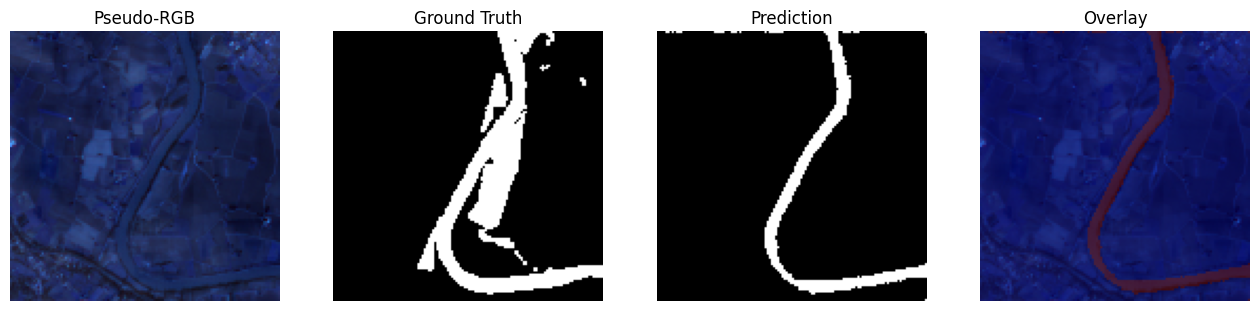

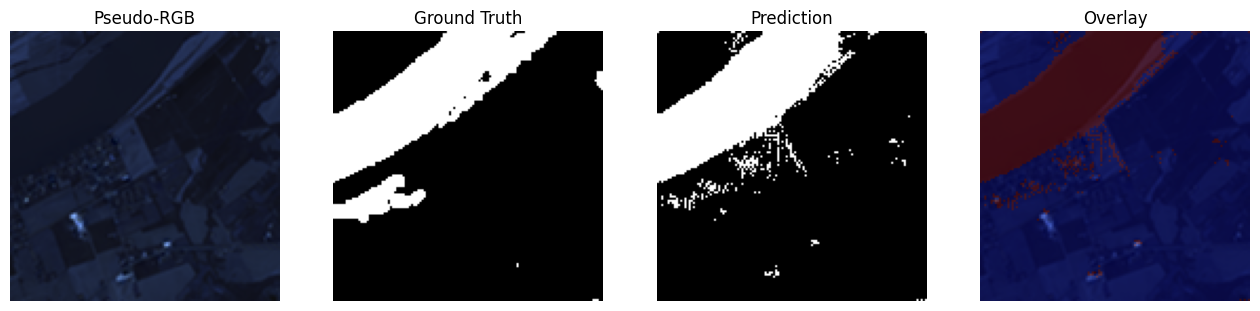

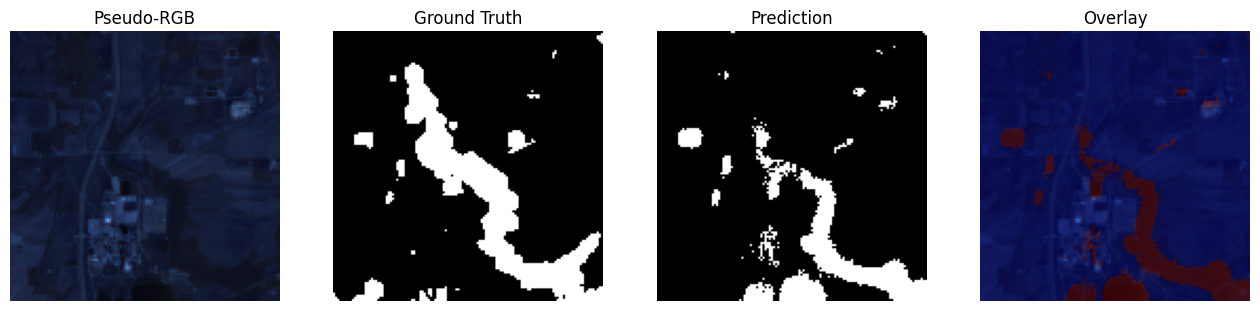

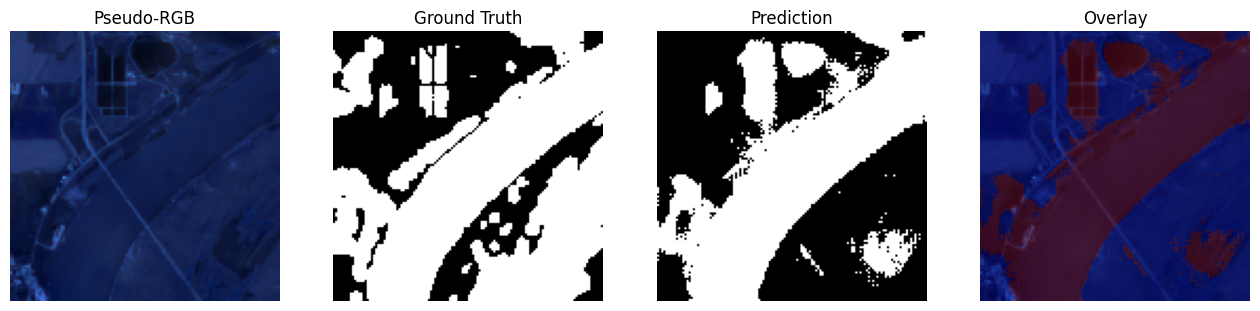

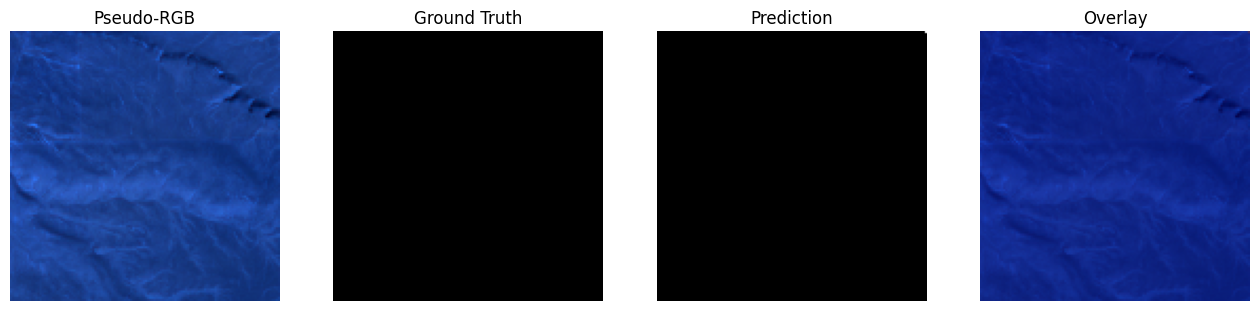

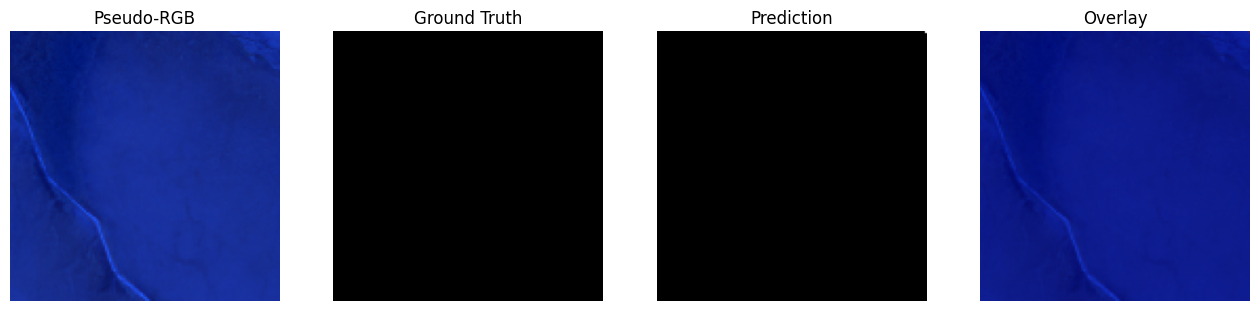

In [20]:
def show_prediction(idx):
    fig, axs = plt.subplots(1,4, figsize=(16,4))
    rgb = X_val[idx][:,:,:3]*band_stds[:3].reshape(1,1,3)+band_means[:3].reshape(1,1,3)
    rgb_disp = (rgb - rgb.min())/(rgb.max()-rgb.min()+1e-8)
    axs[0].imshow(rgb_disp); axs[0].set_title('Pseudo-RGB'); axs[0].axis('off')
    axs[1].imshow(Y_val[idx], cmap='gray'); axs[1].set_title('Ground Truth'); axs[1].axis('off')
    axs[2].imshow(val_preds_bin[idx], cmap='gray'); axs[2].set_title('Prediction'); axs[2].axis('off')
    axs[3].imshow(rgb_disp); axs[3].imshow(val_preds_bin[idx], cmap='jet', alpha=0.4)
    axs[3].set_title('Overlay'); axs[3].axis('off')
    plt.show()

for i in range(min(6, len(Y_val))):
    show_prediction(i)

Plot training curves

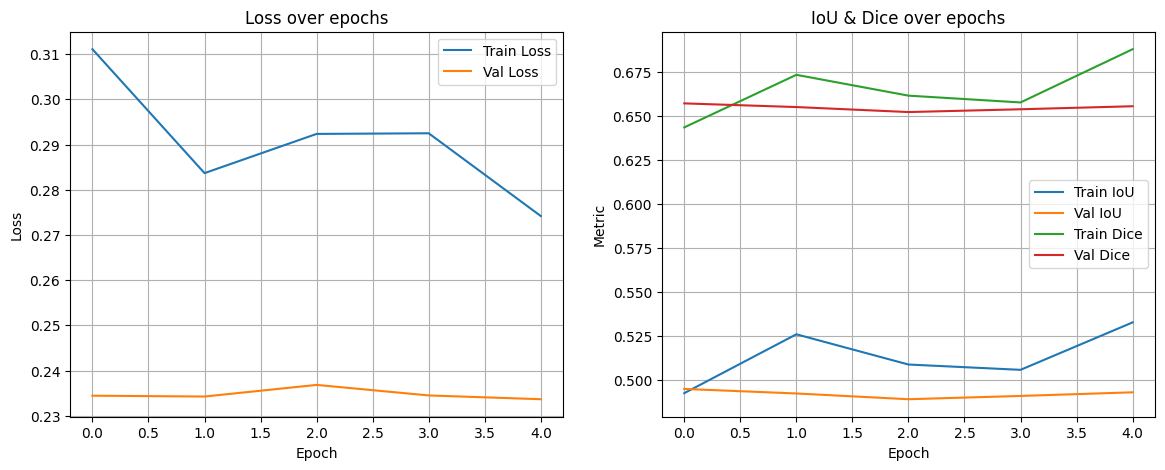

In [22]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    # Check if history is not None
    if history is None or not hasattr(history, 'history'):
        print("No training history available to plot.")
        return

    fig, axs = plt.subplots(1,2, figsize=(14,5))

    # Loss
    if 'loss' in history.history and 'val_loss' in history.history:
        axs[0].plot(history.history['loss'], label='Train Loss')
        axs[0].plot(history.history['val_loss'], label='Val Loss')
        axs[0].set_title('Loss over epochs')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True)

    # IoU & Dice
    metrics = ['iou_metric', 'val_iou_metric', 'dice_coef', 'val_dice_coef']
    for m in metrics:
        if m not in history.history:
            print(f"Metric {m} not found in history.")

    axs[1].plot(history.history.get('iou_metric', []), label='Train IoU')
    axs[1].plot(history.history.get('val_iou_metric', []), label='Val IoU')
    axs[1].plot(history.history.get('dice_coef', []), label='Train Dice')
    axs[1].plot(history.history.get('val_dice_coef', []), label='Val Dice')
    axs[1].set_title('IoU & Dice over epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Metric')
    axs[1].legend()
    axs[1].grid(True)

    plt.show()

# Call it with the existing history
plot_training_history(history)
